New stis data!!!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
path = '/media/david/5tb_storage1/eg_uma/hst/stis/data/'
x1ds = glob.glob('{}*x1d.fits'.format(path))
x1ds

['/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua1010_x1d.fits',
 '/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua2010_x1d.fits',
 '/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua4010_x1d.fits']

1194.553066804444 1249.0873405005793


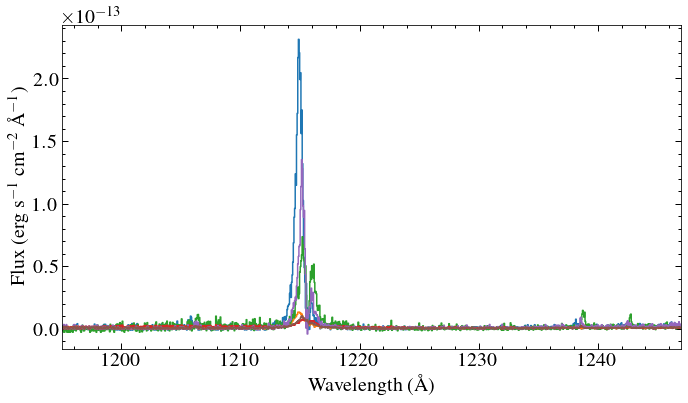

In [4]:
plt.figure(figsize=(10,6))
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    plt.step(data['WAVELENGTH'],data['FLUX'])
    plt.step(data['WAVELENGTH'],data['ERROR'])
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.tight_layout()
plt.xlim(1195, 1247)
# plt.savefig('plots/1st_look.png', dpi=150)
print(data['WAVELENGTH'][0], data['WAVELENGTH'][-1])

(-1e-15, 1e-14)

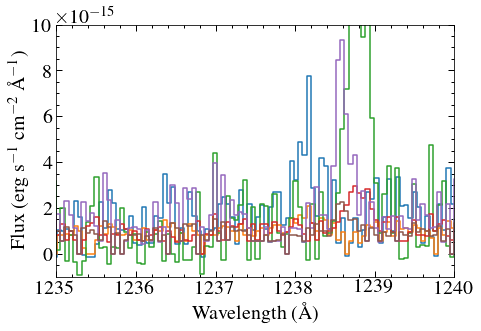

In [5]:
plt.figure(figsize=(7,5))
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    plt.step(data['WAVELENGTH'],data['FLUX'])
    plt.step(data['WAVELENGTH'],data['ERROR'])
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.tight_layout()
plt.xlim(1235, 1240)
plt.ylim(-0.1e-14, 1e-14)

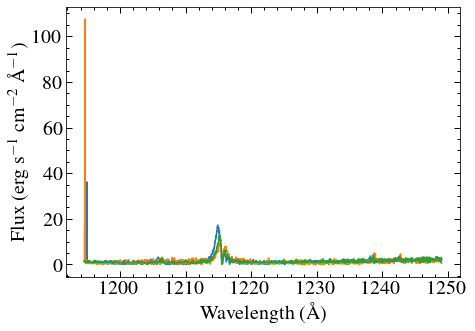

In [6]:
plt.figure(figsize=(7,5))
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    mask = (data['FLUX'] > 0)
    plt.step(data['WAVELENGTH'][mask],abs(data['FLUX'][mask]/data['ERROR'][mask]))
    
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.tight_layout()


In [7]:
# Si III,1206.499,High,4.8
# N V,1238.821,High,5.3
# N V,1242.804,High,5.3

In [8]:
lines = [1206.499, 1238.821, 1242.804]
names = ['Si\,{\sc iii}', 'N\,{\sc v}', 'N\,{\sc v}']
fitter = fitting.LevMarLSQFitter()
lya = 1215.67

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
              c0                     c1                     c2          
    ---------------------- ---------------------- ----------------------
    2.5321493455779784e-12 -4.171764250868645e-15 1.7185400064815264e-18


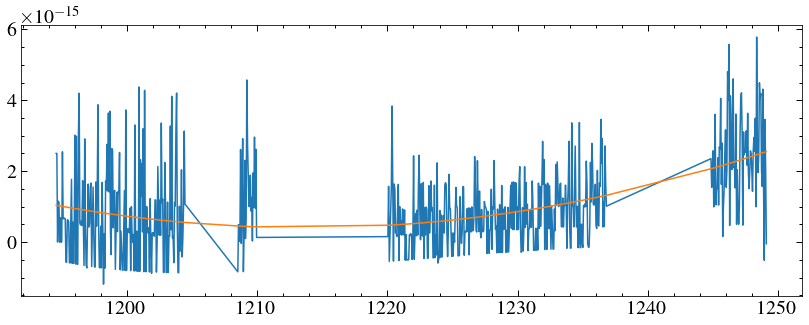

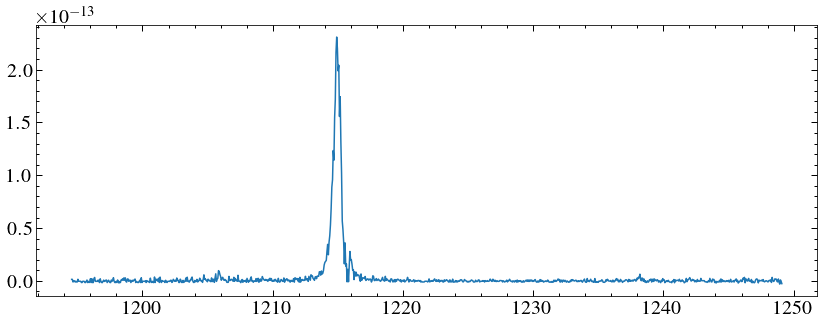

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
              c0                     c1                     c2         
    ---------------------- ---------------------- ---------------------
    1.1456441367871683e-12 -1.891696725448723e-15 7.813173794943833e-19


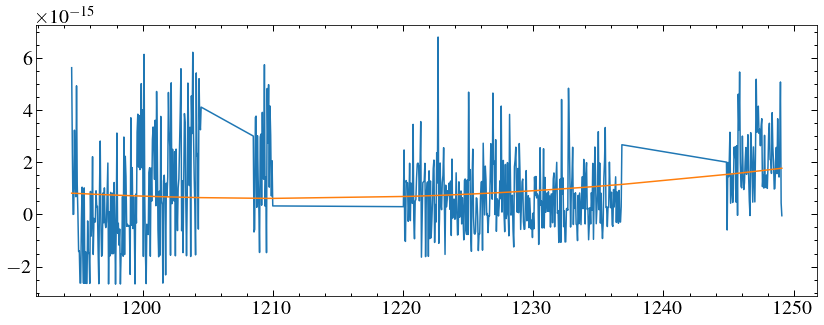

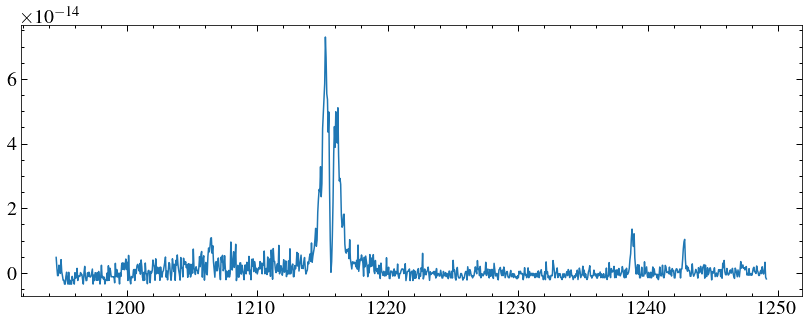

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
              c0                     c1                     c2          
    ---------------------- ---------------------- ----------------------
    3.2397453645405156e-12 -5.335002094825681e-15 2.1965228287585584e-18


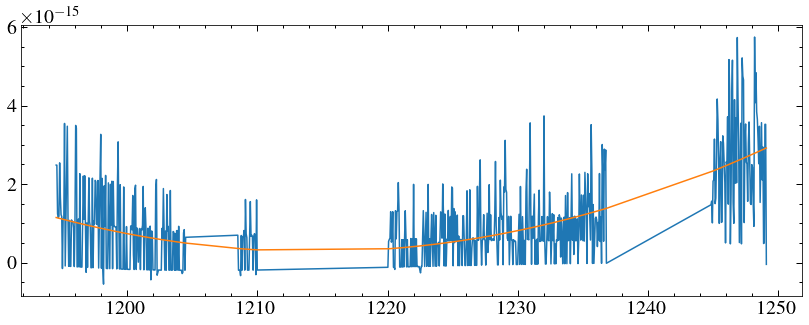

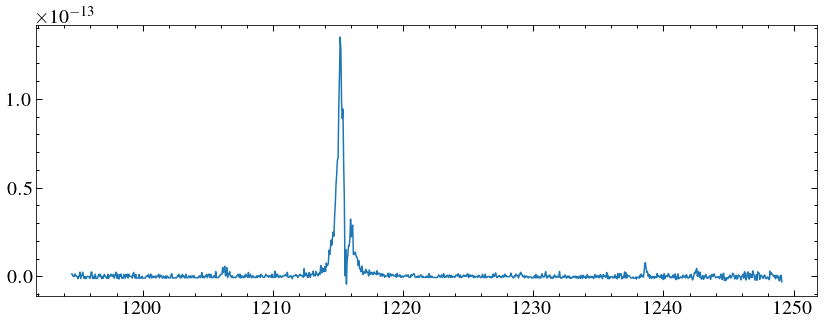

In [9]:
#cleaning off the WD spectrum, use a ploynomial rather than a model 
for i, x in enumerate(x1ds):
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    stis_mask = (w < lines[0]-2) | (w > lines[0]+2) & (w < 1210) | (w > 1220) & (w < lines[1]-2) | (w > lines[1]+2) & (w < lines[2]-2) | (w > lines[2]+2) 
    wi, fi, ei = w[stis_mask], f[stis_mask], e[stis_mask]
    poly_init = models.Polynomial1D(2)
    poly_fit =  fitting.LinearLSQFitter()(poly_init, wi, fi)#, weights = 1/ei)
    print(poly_fit)
    plt.plot(wi, fi)
    plt.plot(wi, poly_fit(wi))
    #plt.plot(wi, ei)
    plt.show()
    plt.plot(w, f-poly_fit(w))
    plt.show()



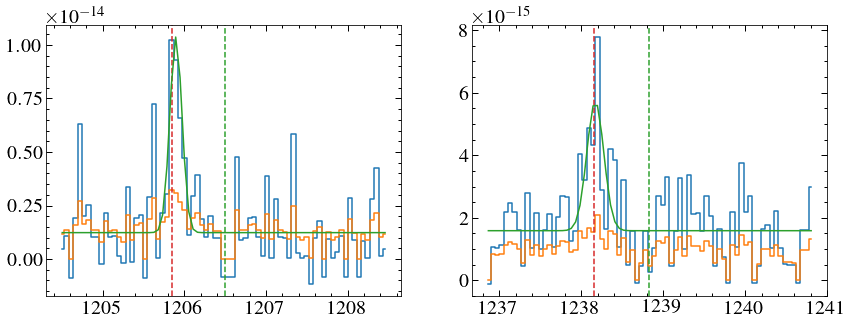

-152.3798882869303 3.6473614077962075


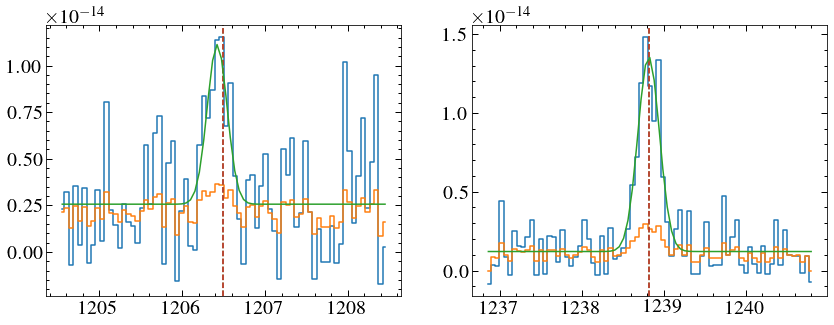

-3.347179172658746 5.5753229266560025


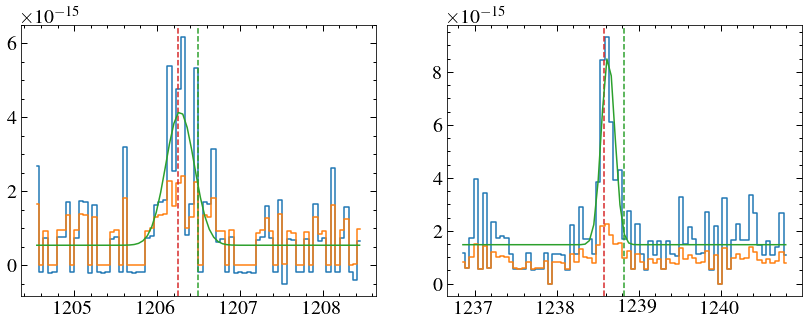

-47.95553817634172 2.978066060322101


In [10]:
def gauss_flux(amp, std, off, ae, se, oe):
    """
    Calcualates the flux and error of a Gaussian with amplitude and stddev amp and std, with offset off
    """
    off_err = 0
    if off != 0.0:
        amp += (-1*off)
        off_err = (oe/off)**2
        
    flux = ((2*np.pi)**0.5) * amp * std
    error = flux * (((ae/amp)**2)+((se/std)**2)+off_err)**0.5
    return flux, error



def dv_average(dvs, es):
    """
    Returns a variance-weighted dv with standard error of the weighted mean (variance weights, scale corrected).
    
    """
    weights = 1 / (es**2)
    dv = np.average(dvs, weights = weights)
    var = 1 / np.sum(weights)
    rcs = np.sum((((dv - dvs)**2) * weights)) / (len(dvs)-1) #reduced chi-squared
    error = (var * rcs)**0.5
    return dv, error

deltavs = []
deltav_errs = []

line_fluxes = np.ndarray(shape=(len(x1ds), len(lines[:2])))
line_errors = np.ndarray(shape=(len(x1ds), len(lines[:2])))

line_dvs = np.ndarray(shape=(len(x1ds), len(lines[:2])))
line_dves = np.ndarray(shape=(len(x1ds), len(lines[:2])))

dates = []
v_helios = []

guess_dv = np.array([-160, 0, -60])*u.km/u.s
for i, x in enumerate(x1ds):
    data = fits.getdata(x, 1)[0]
    hdr = fits.getheader(x, 1)
    tstart, tend = (hdr['EXPSTART']), (hdr['EXPEND']) #mjd
    v_helios.append(hdr['V_HELIO'])
    dates.append((tstart+tend)/2)
    
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    stis_mask = (w < lines[0]-2) | (w > lines[0]+2) & (w < 1210) | (w > 1220) & (w < lines[1]-2) | (w > lines[1]+2) & (w < lines[2]-2) | (w > lines[2]+2) 
    wi, fi, ei = w[stis_mask], f[stis_mask], e[stis_mask]
    poly_init = models.Polynomial1D(2)
    poly_fit =  fitting.LinearLSQFitter()(poly_init, wi, fi)#, weights = 1/ei)
 #   f = f - poly_fit(w)
    
    dvs = []
    dves = []
    for j, line in enumerate(lines[:2]): #nv 1242 is only barely detected
        plt.subplot(1, 2, j+1)
        guess_line = guess_dv[i].to(u.AA,  equivalencies=u.doppler_optical(line*u.AA)).value
#         print(guess_line)
        mask = (w > line-2) & (w < line+2)
        wline, fline, eline = w[mask], f[mask], e[mask]
        plt.step(wline, fline, where='mid')
        plt.step(wline, eline, where='mid')
        plt.axvline(line, ls='--', c='C2')
        plt.axvline(guess_line, ls='--', c='C3')
        gg_init = models.Const1D(0)+models.Gaussian1D(1e-14, guess_line, 0.1)
        gg_fit = fitter(gg_init, wline, fline, maxiter=100000)
      #  print(gg_fit)
        fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
       # print(fit_e)
        plt.plot(wline, gg_fit(wline))
        obs_line = gg_fit[1].mean.value*u.AA
        dv = obs_line.to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA))
       # print(fit_e)
        eup = (obs_line+fit_e[2]*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA))
        edo = (obs_line-fit_e[2]*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA))
        dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s
#         print(dv, dve)
        dvs.append(dv.value)
        dves.append(dve.value)
        
        line_flux, line_fluxerr = gauss_flux(gg_fit[1].amplitude, gg_fit[1].stddev, gg_fit[0].amplitude, fit_e[1], fit_e[3], fit_e[0])
       # print(line_flux, line_fluxerr)
        line_fluxes[i, j] = line_flux
        line_errors[i, j] = line_fluxerr
        line_dvs[i, j] = dv.value
        line_dves[i, j] = dve.value
      #  print(line_fluxes) 
    plt.show()
    dv_spec, dve_spec = dv_average(np.array(dvs), np.array(dves))
    deltavs.append(dv_spec)
    deltav_errs.append(dve_spec)
    print(dv_spec, dve_spec)
       
dates, deltavs, deltav_errs = np.array(dates), np.array(deltavs), np.array(deltav_errs)
     

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


59306


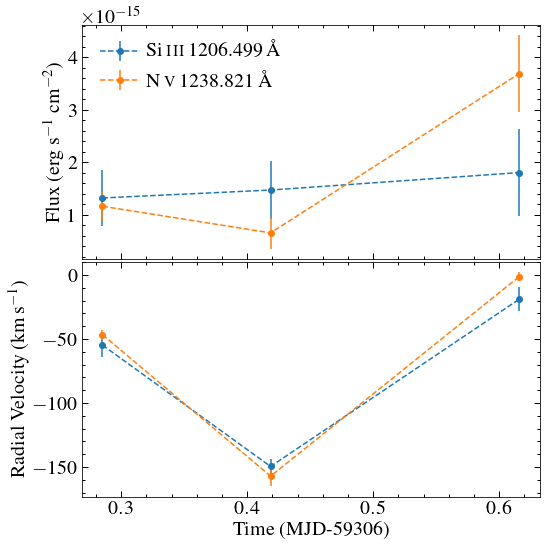

In [11]:
import math as mt
# print(line_fluxes)
# print(line_fluxes[:,0])
plt.figure(figsize=(8,8))

args = np.argsort(dates)
day = mt.floor(np.min(dates))
print(day)
plt.subplot(211)

for i in range(len(lines[:2])):
    plt.errorbar(dates[args]-day, line_fluxes[:,i][args], yerr=line_errors[:,i][args], ls='--', marker='o', label = '{}\,{}\,\AA'.format(names[i], lines[i]))
plt.legend()
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$)')
plt.xticks(visible=False)

plt.subplot(212)
for i in range(len(lines[:2])):
    plt.errorbar(dates[args]-day, line_dvs[:,i][args], yerr=line_dves[:,i][args], ls='--', marker='o', label = '{}\,{}\,\AA'.format(names[i], lines[i]))
# plt.legend()
plt.xlabel('Time (MJD-{})'.format(day))
plt.ylabel('Radial Velocity (km\,s$^{-1}$)')
plt.tight_layout()
plt.subplots_adjust(hspace=0.01)

In [12]:
lyatab = Table.read('EGUMa_LyA_ISM_estimate.txt', format='ascii.basic')


/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua1010_x1d.fits -152
/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua2010_x1d.fits -3
/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua4010_x1d.fits -48.0


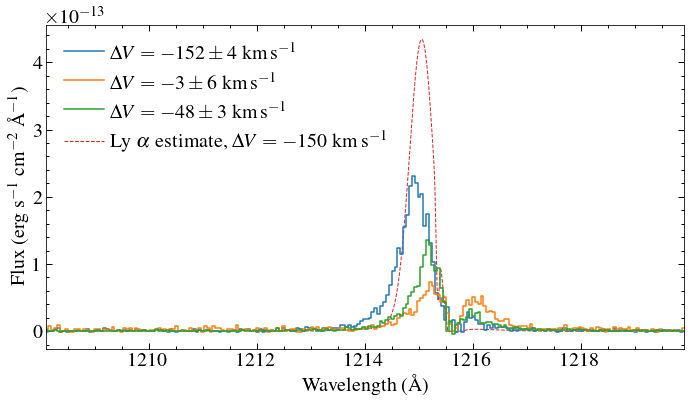

In [13]:
dv_labs = [-152,-3, -48.0]
dve_labs = [3.5, 5, 3.0]

plt.figure(figsize=(10,6))
for i, x in enumerate(x1ds):
    print(x, dv_labs[i])
    data = fits.getdata(x, 1)[0]
    plt.step(data['WAVELENGTH'],data['FLUX'], label = r'$\Delta V = {0:.0f}\pm{1:.0f}$'.format(deltavs[i], deltav_errs[i]) +' km\,s$^{-1}$')
plt.plot(lyatab['wave'], lyatab['flux_-150kms']*lyatab['ISM_attenuation'], label=r'Ly $\alpha$ estimate, $\Delta V = -150$ km\,s$^{-1}$', c='C3', lw=1, ls='--', zorder=-1)

plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(loc=2)
plt.xlim(1208.1, 1219.9)
plt.tight_layout()
# plt.savefig('plots/1st_look_model.png', dpi=150)

In [14]:
# lyatab

Compare with COS

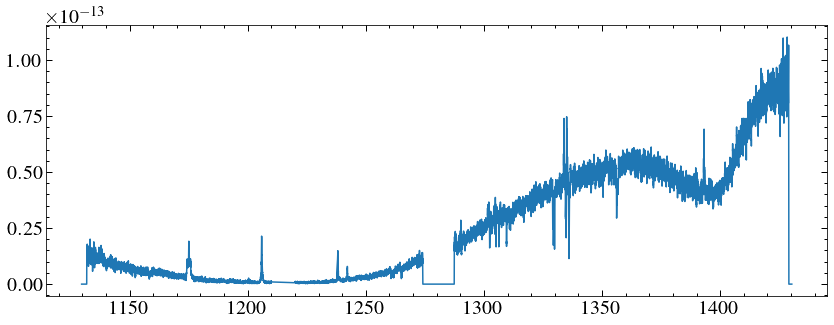

In [36]:
cpath = '/media/david/5tb_storage1/pceb_data/eg_uma/'
cx = glob.glob('{}*x1dsum.fits'.format(cpath))[0]

smooth=5
data = fits.getdata(cx, 1)
wc = np.array([], dtype=float)
fc = np.array([], dtype=float)
ec = np.array([], dtype=float)
for dt in data[::-1]:
    wi, fi, ei, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
   # mask = (fi>0) & (dq == 0) & (wi < 1213) | (wi > 1217) & (fi>0) & (dq == 0) 
    mask = (dq==0)
    wi, fi, ei = wi[mask], fi[mask], ei[mask]
    wc = np.concatenate((wc, wi))
    fc = np.concatenate((fc, fi))
    ec = np.concatenate((ec, ei))    

fc = convolve(fc,Box1DKernel(smooth))
ec = convolve(ec,Box1DKernel(smooth))/(smooth**0.5)

# plt.plot(wc, fc)

mask = (wc < 1210) | (wc > 1220)
wc1, fc1, ec1 = wc[mask], fc[mask], ec[mask]
plt.plot(wc1, fc1)

In [16]:
data = fits.getdata(x1ds[0])[0]
ws, fs, es = data['WAVELENGTH'], data['FLUX'], data['ERROR']

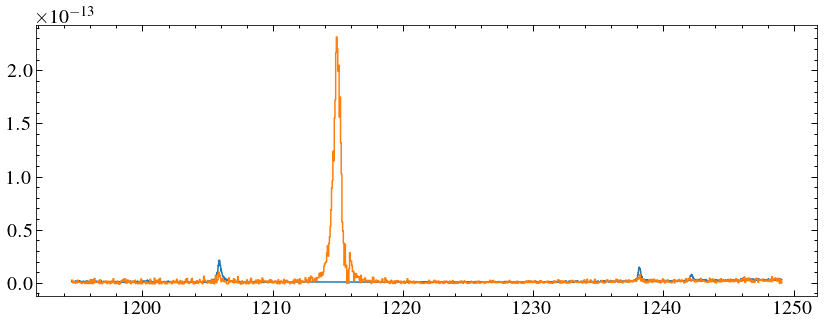

In [17]:
mask = (wc1 > ws[0]) & (wc1 < ws[-1])
plt.plot(wc1[mask], fc1[mask])
plt.step(ws, fs, where='mid')

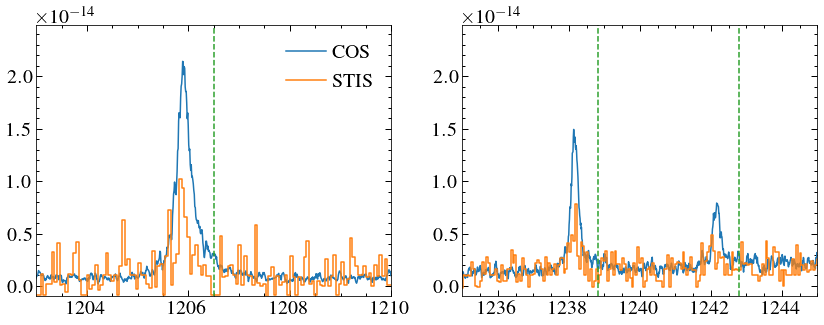

In [18]:
plt.subplot(121)
plt.plot(wc1[mask], fc1[mask], label='COS')
plt.step(ws, fs, where='mid', label='STIS')
plt.xlim(1203, 1210)
plt.ylim(-1e-15, 2.49e-14)
[plt.axvline(line, c='C2', ls='--') for line in lines]
plt.legend()

plt.subplot(122)
plt.plot(wc1[mask], fc1[mask])
plt.step(ws, fs, where='mid')
plt.xlim(1235, 1245)
plt.ylim(-1e-15, 2.49e-14)
[plt.axvline(line, c='C2', ls='--') for line in lines]

Is the COS and STIS wd flux consitant? 

5.585796213024902e-14
6.300544228989636e-14
0.8865577337468589


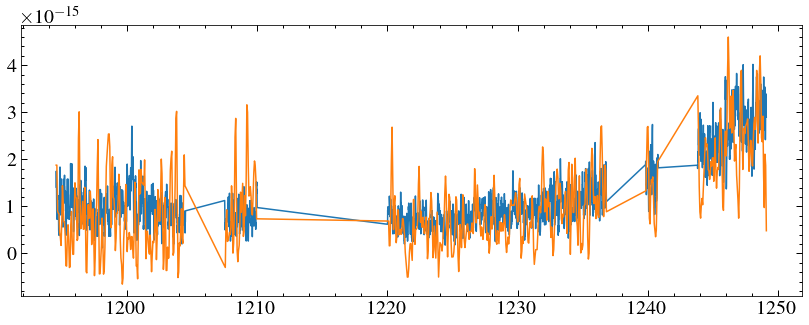

In [19]:
cos_mask = (wc >= ws[0]) & (wc < lines[0]-2) | (wc > lines[0]+1) & (wc < 1210) | (wc > 1220) & (wc < lines[1]-2) | (wc > lines[1]+1) & (wc < lines[2]-2) | (wc > lines[2]+1) & (wc <=ws[-1])
plt.plot(wc[cos_mask], fc[cos_mask])
stis_mask = (ws < lines[0]-2) | (ws > lines[0]+1) & (ws < 1210) | (ws > 1220) & (ws < lines[1]-2) | (ws > lines[1]+1) & (ws < lines[2]-2) | (ws > lines[2]+1) 


fsi = convolve(fs,Box1DKernel(2))
plt.plot(ws[stis_mask], fsi[stis_mask])

stis_int = np.trapz(fsi[stis_mask], ws[stis_mask])
cos_int = np.trapz(fc[cos_mask], wc[cos_mask])
print(stis_int)
print(cos_int)
print(stis_int/cos_int)

Where are they in phase space?

2458093.22951347 2458093.25927032
-138.6352434900658 2.11867788687639


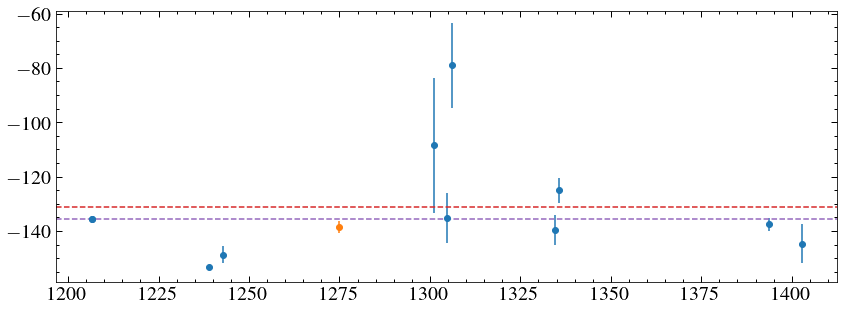

In [48]:
#loading the COS RVs as another point
coslines = Table.read('eg_uma_line_fluxes.ecsv')
mask = (coslines['ION'] != 'C III') & (coslines['FLUX'] != -1.0)
coslines = coslines[mask]
chdr = fits.getheader(cx, 1)
cstart, cend = chdr['EXPSTRTJ'], chdr['EXPENDJ']
print(cstart, cend)
# chdr

cdv, cdve = dv_average(coslines['VELOCITY'], coslines['VELOCITY_ERROR'])
print(cdv, cdve)
plt.errorbar(coslines['WAVELENGTH'], coslines['VELOCITY'], yerr=coslines['VELOCITY_ERROR'], ls='none', marker='o')
plt.errorbar(1275, cdv, yerr=cdve, ls='none', marker='o')
plt.axhline(np.mean(coslines['VELOCITY']), ls='--', c='C3')
plt.axhline(np.median(coslines['VELOCITY']), ls='--', c='C4')

-4.209317984083981 km / s
18.590217048770057 km / s
-18.5519687314265 km / s


AttributeError: 'numpy.ndarray' object has no attribute 'append'

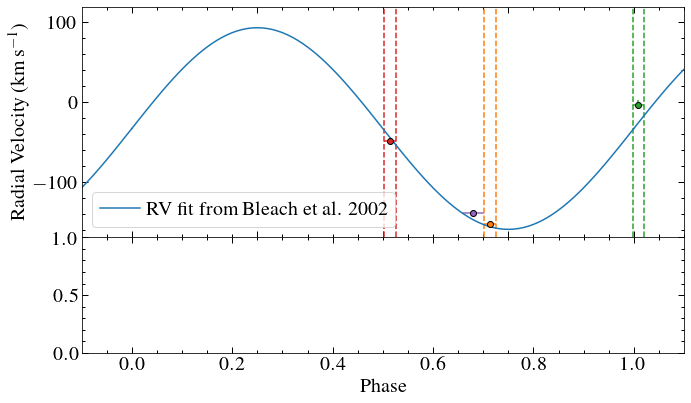

In [54]:
gamma = -32.9*u.km/u.s
#k2 = 124.9*u.km/u.s
k2 = 126.0*u.km/u.s # (2.5)
p = 961.31*u.min
pd = 0.66757877*u.d #(54)
eph =2444279.9151*u.d #(18)

fold_error = ((0.0018*u.d/eph)**2+(0.00000054*u.d/pd)**2)*0.05



phase_time = np.arange(0,1.01, 0.01)
phase_orbit = models.Sine1D(k2, 1, 0)+models.Const1D(gamma)
phase_curve = phase_orbit(phase_time)

fig, ax, = plt.subplots(figsize=(10,6))
gs = GridSpec(3, 1)
phasemids = []


eg_uma = coord.SkyCoord(183.93308097127309, 52.51643832583794,
                        unit=(u.deg, u.deg), frame='icrs')
pole = coord.EarthLocation(0, 0,0*u.m)  
 


plt.subplot(gs[:2])
for i, x in enumerate(x1ds):
    hdr = fits.getheader(x, 1)
    tstart, tend = (hdr['EXPSTART']), (hdr['EXPEND']) #mjd
    #print(tstart, tend)
    times = time.Time([tstart, tend], format='mjd',scale='utc', location = pole) 
    ltt_helio = times.light_travel_time(eg_uma, 'heliocentric') 
    #print(times)
    #print(ltt_helio)
    tstart, tend = (times.utc + ltt_helio)[0]+2400000.5, (times.utc + ltt_helio)[1]+2400000.5  #HJD correction
   # print(tstart, tend)
    pstart, pend = ((tstart - eph)/pd).value % 1, ((tend - eph)/pd).value % 1 
    if pend < pstart:
        pend +=1
    phasemid = (pstart+pend)/2 
    phasemids.append((pstart+pend)/2)
    print(phase_orbit(pend) - phase_orbit(pstart))
    [plt.axvline(line, ls='--', c='C{}'.format(i+1)) for line in (pstart, pend)]
    
    plt.errorbar(phasemid, deltavs[i], yerr=deltav_errs[i], xerr=[[phasemid-pstart], [pend-phasemid]], marker='o', ls='none', c='C{}'.format(i+1), markeredgecolor='k')

    
#cos data
times = time.Time([cstart, cend], format='mjd',scale='utc', location = pole) 
ltt_helio = times.light_travel_time(eg_uma, 'heliocentric') 
tstart, tend = (times.utc + ltt_helio)[0], (times.utc + ltt_helio)[1]  #HJD correction. Note COS in JD not MJD
pstart, pend = ((tstart - eph)/pd).value % 1, ((tend - eph)/pd).value % 1 
if pend < pstart:
    pend +=1
phasemid = (pstart+pend)/2 
phasemids.append((pstart+pend)/2)
# print(phase_orbit(pend) - phase_orbit(pstart))
# [plt.axvline(line, ls='--', c='C{}'.format(len(x1ds)+1)) for line in (pstart, pend)]
plt.errorbar(phasemid, cdv, yerr=cdve, xerr=[[phasemid-pstart], [pend-phasemid]], marker='o', ls='none', c='C{}'.format(len(x1ds)+1), markeredgecolor='k')
    
    
plt.plot(phase_time, phase_curve, c='C0', label=('RV fit from Bleach et al. 2002'))#orbit(model_time))
plt.plot(phase_time-1, phase_curve, c='C0')#orbit(model_time))
plt.plot(phase_time+1, phase_curve, c='C0')#orbit(model_time))
plt.xlim(-0.249, 1.1)

# plt.errorbar(phasemids, deltavs, yerr=deltav_errs, xerr=phasemids*fold_error, marker='o', ls='none')
# for i in range(len(lines[:2])):
#     plt.errorbar(phasemids, line_dvs[:,i], yerr=line_dves[:,i], marker='o', ls='none', label = '{}\,{}\,\AA'.format(names[i], lines[i]))


dv_predict = phase_orbit(phasemids)
# print(deltavs)
# print(dv_predict)

#plt.axhline(0, ls='--', c='C2')

# [plt.annotate(labels[i],(obs_phases[i], labpos[i]), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none')) for i in range(len(obs_phases))]
plt.xticks((0.0, 0.25, 0.5, 0.75, 1))
plt.ylim(-169, 119)

plt.ylabel('Radial Velocity (km\,s$^{-1}$)')

plt.xticks(visible=False)

plt.xlim(-0.1, 1.1)
plt.legend(frameon=True)


plt.subplot(gs[2:])

plt.xlim(-0.1, 1.1)
plt.xlabel('Phase')

plt.tight_layout()
plt.subplots_adjust(hspace=0)
oc = np.append(deltavs, cdv) - dv_predict.value
for i, x in enumerate(x1ds):
    plt.errorbar(phasemids[i], oc[i], yerr=np.appedeltav_errs.append(cdve)[i], xerr=[[phasemid-pstart], [pend-phasemid]], marker='o', ls='none', c='C{}'.format(i+1), markeredgecolor='k')
plt.axhline(0, ls='--', c='C4')
plt.ylabel('O-C (km\,s$^{-1}$)')
# plt.savefig('plots/rv_curve.pdf', dpi=150)

HJD correction? Don't think so? Could add the COS spectrum.

In [22]:
# fits.getheader(x, 1)

Light curves have been made, don't show anything but can make a nice plot.

In [23]:
lcs = glob.glob('lc_output/*100s_lc.ecsv')
lcs

['lc_output/oehua1010_100s_lc.ecsv',
 'lc_output/oehua4010_100s_lc.ecsv',
 'lc_output/oehua2010_100s_lc.ecsv']

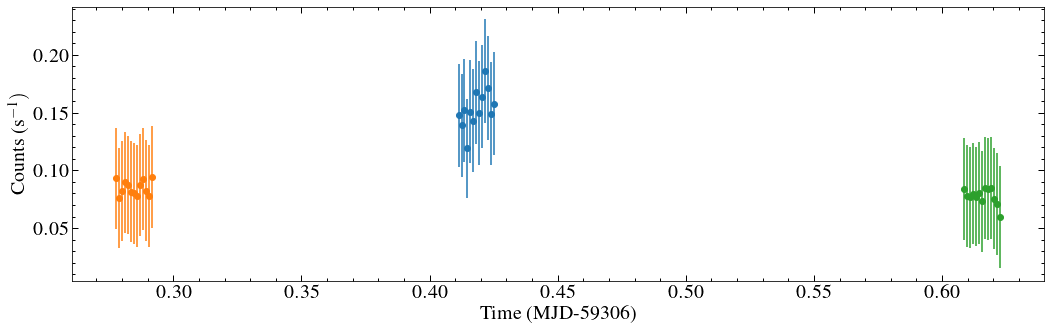

In [24]:
plt.figure(figsize=(len(lcs)*5, 5))

for i, lc in enumerate(lcs):
    #plt.subplot(1, len(lcs), i+1)
    data= Table.read(lc)
    t,f,e = data['TIME'], data['FLUX'], data['ERROR']
    plt.errorbar(t-day, f, yerr = e, marker='o', ls='none') #plot the light curve
    #if i == 0:
plt.ylabel('Counts (s$^{-1})$')
    #if i == 1:
plt.xlabel('Time (MJD-{})'.format(day))
#plt.ylim(0.1*min(f), 2*max(f))
plt.tight_layout()

In [25]:
#barycorr

In [26]:
from astropy import time, coordinates as coord, units as u
ip_peg = coord.SkyCoord("23:23:08.55", "+18:24:59.3",
                        unit=(u.hourangle, u.deg), frame='icrs')
pole = coord.EarthLocation(0, 0,0*u.m)  
times = time.Time([56325.95833333, 56325.978254], format='mjd',
                  scale='utc', location = pole)  
ltt_bary = times.light_travel_time(ip_peg)  
print(ltt_bary) 

ltt_helio = times.light_travel_time(ip_peg, 'heliocentric') 
print(ltt_helio) 

[-0.00377162 -0.00377298]
[-0.00376588 -0.00376724]


In [27]:
ltt_helio.value[0]

-0.003765875525078968

/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua1010_x1d.fits -152
/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua2010_x1d.fits -3
/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua4010_x1d.fits -48.0


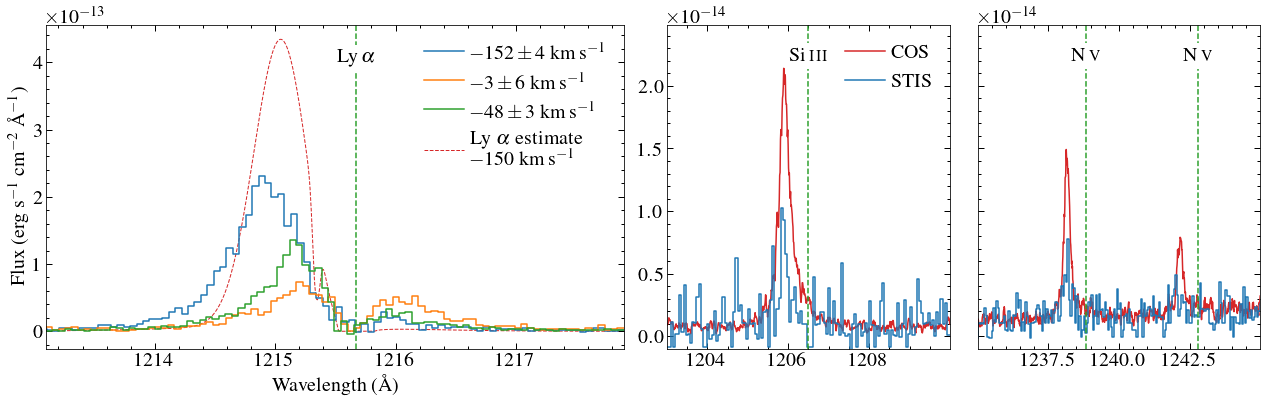

In [28]:
dv_labs = [-152,-3, -48.0]
dve_labs = [3.5, 5, 3.0]

plt.figure(figsize=(18,6))
plt.subplot(121)
for i, x in enumerate(x1ds):
    print(x, dv_labs[i])
    data = fits.getdata(x, 1)[0]
    plt.step(data['WAVELENGTH'],data['FLUX'], label = r'$ {0:.0f}\pm{1:.0f}$'.format(deltavs[i], deltav_errs[i]) +' km\,s$^{-1}$')
plt.plot(lyatab['wave'], lyatab['flux_-150kms']*lyatab['ISM_attenuation'], label=r'Ly $\alpha$ estimate'+'\n'+'$ -150$ km\,s$^{-1}$', c='C3', lw=1, ls='--', zorder=-1)

plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(loc=1)
plt.xlim(1213.1, 1217.9)
plt.axvline(lya, c='C2', ls='--')
plt.annotate(r'Ly\,$\alpha$',(lya, 4e-13), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))


data = fits.getdata(x1ds[0])[0]
ws, fs, es = data['WAVELENGTH'], data['FLUX'], data['ERROR']
# fs = convolve(fs,Box1DKernel(2))

mask = (wc1 > ws[0]) & (wc1 < ws[-1])


plt.subplot(143)
plt.plot(wc1[mask], fc1[mask], label='COS', c='C3')
plt.step(ws, fs, where='mid', label='STIS')
plt.xlim(1203.01, 1209.99)
plt.ylim(-1e-15, 2.49e-14)
[plt.axvline(line, c='C2', ls='--') for line in lines]
plt.annotate(names[0],(lines[0], 2.2e-14), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))
plt.legend()



plt.subplot(144)
plt.plot(wc1[mask], fc1[mask], c='C3')
plt.step(ws, fs, where='mid')
plt.xlim(1235.01, 1244.99)
plt.ylim(-1e-15, 2.49e-14)
[plt.axvline(line, c='C2', ls='--') for line in lines]
[plt.annotate(name,(line, 2.2e-14), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none')) for name, line in zip(names[1:], lines[1:])]

plt.yticks(visible=False)


plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig('plots/stis_v_cos_3specs.png', dpi=150)

In [29]:
eg_uma = coord.SkyCoord(183.93308097127309, 52.51643832583794,
                        unit=(u.deg, u.deg), frame='icrs')

In [30]:
eg_uma

<SkyCoord (ICRS): (ra, dec) in deg
    (183.93308097, 52.51643833)>

In [31]:
(times.utc + ltt_helio)

<Time object: scale='utc' format='mjd' value=[56325.95456745 56325.97448676]>

In [32]:
1.8/1.1

1.6363636363636362

In [33]:
(1.8/1.1)/((7/100)**0.5)

6.184873194696444

In [35]:
x

'/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua4010_x1d.fits'